For this project, we will use Sentimental Analysis with Naive Bayes classifier to sort out Twitter's tweets into postive, neutral or negative emotions. This code will consist of 3 parts:
1. Organise training, validation and test data and load them into the system.
2. Develop a Naïve Bayes classifier (including optimising the hyper-parameters when needed) with the training set.
3. Conduct a systematic evaluation of the trained classifier on the test set.

Firstly, we will load the data set and process the data.

In [2]:
import pandas as pd

#Load the dataset
#Dataset 1
url1 = [
    "https://huggingface.co/datasets/Sp1786/multiclass-sentiment-analysis-dataset/resolve/main/train_df.csv",
    "https://huggingface.co/datasets/Sp1786/multiclass-sentiment-analysis-dataset/resolve/main/test_df.csv",
    "https://huggingface.co/datasets/Sp1786/multiclass-sentiment-analysis-dataset/resolve/main/val_df.csv"
]

df_data_1 = pd.concat([pd.read_csv(url) for url in url1], ignore_index=True)

#Dataset 2
url2 = [
    "https://huggingface.co/datasets/mteb/tweet_sentiment_extraction/resolve/main/train.jsonl",
    "https://huggingface.co/datasets/mteb/tweet_sentiment_extraction/resolve/main/test.jsonl"
]
df_data2 = pd.concat([pd.read_json(url, lines=True) for url in url2], ignore_index=True)

#Rename df_data2[label_text] to df_data2[sentiment]
df_data2.rename(columns={'label_text': 'sentiment'}, inplace=True)

#Combine both datasets
df_data = pd.concat([df_data_1, df_data2], ignore_index=True)

df_data.head()

,id,text,label,sentiment
0,9536,"Cooking microwave pizzas, yummy",2,positive
1,6135,Any plans of allowing sub tasks to show up in ...,1,neutral
2,17697,"I love the humor, I just reworded it. Like sa...",2,positive
3,14182,naw idk what ur talkin about,1,neutral
4,17840,That sucks to hear. I hate days like that,0,negative


We use the Natural Language Toolkit(NLTK) which is a comprehensive library for working with human language data. NLTK provides useful tools for text processing such as tokenization and lemmitization. Here is a quick overview and explanation of the other imports used in this portion of the code:
1. The punkt tonkenizer model is used for dividing a text into a list of words or sentences. This is needed for tokenization tasks.
2. A list of stopwords like "and", "is", "the", etc is downloaded which is often removed from text data to focus on more meaningful words.
3. The WordNet database provides a large dictionary of words and their meanings, synonyms and antonymns. This is used for lemmatization where words are reduced to their base forms.
4. The Open Multilingual WordNet package allows access to WordNet in multiple languages. Our dataset is multilingual so this helps us in multilingual text processing.
5. Words is a list of English words which is used to filter or validate tokens to ensure that they are real words.
6. 'word_tokenize' is a function that breaks down text into individual words.
7. 'WordNetLemmatizer' is a tool that reduces words to their base form, eg 'running' to 'run'.

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('words')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
import string
import re

#Data processing
#Convert text to lowercase
df_data['text'] = df_data['text'].str.lower()

#Function to remove punctuation
def remove_punctuation(text):
    if isinstance(text, str):
        return re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    else:
        return text  # or return an empty string: ''

#Apply punctuation removal to the text column
df_data['text'] = df_data['text'].apply(remove_punctuation)

#Function to remove stop words
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        filtered_tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(filtered_tokens)
    else:
        return text

#Apply stop word removal to the text column
df_data['text'] = df_data['text'].apply(remove_stop_words)

#Function to tokenize text
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return []

#Apply tokenization to the text column
df_data['tokens'] = df_data['text'].apply(tokenize_text)

#Function to lemmatize tokens
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    if isinstance(tokens, list):
        return [lemmatizer.lemmatize(token) for token in tokens]
    else:
        return tokens

#Apply lemmatization to the tokens column
df_data['lemmatized_tokens'] = df_data['tokens'].apply(lemmatize_tokens)

# #Load a set of English words
# english_words = set(words.words())

# #Function to remove non-English words
# def remove_non_english_words(tokens):
#     if isinstance(tokens, list):
#         return [token for token in tokens if token in english_words]
#     else:
#         return tokens

# #Apply the removal of non-English words to the lemmatized tokens
# df_data['lemmatized_tokens'] = df_data['lemmatized_tokens'].apply(remove_non_english_words)

#Join lemmatized tokens back into strings
df_data['lemmatized_text'] = df_data['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ssyab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ssyab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ssyab\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ssyab\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\ssyab\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


Next, we will do the test-train split: 70% of the dataset will be used for training the model and the remaining 30% is used for testing. We imported the 'train_test_split' function from scikit-learn module. This separation helps ensure that the model's performance metrics are reliable and that it doesn't overfit to the training data.

We imported 'TfidVectorizer' from the Scikit-learn library where it is used to convert a collection of raw text documents into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features. This matrix quantifies the importance of each word in a document relative to the entire corpus, helping to highlight words that are more relevant to each document.

In [4]:
# Retrieve id = 8112
df_data[df_data['id'] == 8112]

,id,text,label,sentiment,tokens,lemmatized_tokens,lemmatized_text
174,8112,💩👎💩👎💩👎💩 👻☠️ impossible delete list sub lists t...,0,negative,"[💩👎💩👎💩👎💩, 👻☠️, impossible, delete, list, sub, ...","[💩👎💩👎💩👎💩, 👻☠️, impossible, delete, list, sub, ...",💩👎💩👎💩👎💩 👻☠️ impossible delete list sub list ta...
26795,8112,july 21st means concert wont know songs oh wel...,1,neutral,"[july, 21st, means, concert, wont, know, songs...","[july, 21st, mean, concert, wont, know, song, ...",july 21st mean concert wont know song oh well ...


In [5]:
#Join the lemmatized tokens back into a single string
df_data['processed_text'] = df_data['lemmatized_tokens'].apply(lambda tokens: ' '.join(tokens))

In [6]:
#Split the dataframe into inputs and expected outputs
x = df_data['processed_text']
y = df_data['label']

from sklearn.model_selection import train_test_split
#Split x and y into training sets and test sets
#Split the dataset into 70% training and 30% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=4)

from sklearn.feature_extraction.text import TfidfVectorizer
#Initialize CountVectorizer and fit on training data
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
vectorizer.fit(x_train)

#Transform the training and test data
x_train_vectorized = vectorizer.transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

Now we move onto our second phase of the code where we will do the model training, testing and hyperparameter tuning.

We have decided to use the three different types of Naive Bayes Classifier which is the Multinomial, Complement and Bernoulli model and we will compare which model has the best accuracy. We have also calculated the confusion matrix and classification report to help us compare.
1. Accuracy is defined as the porprotion of correct predictions made by the model out of the total number of predictions.
2. The confusion matrix summarizes a classification model's performance by showing true positives, true negatives, false positives, and false negatives.
3. The classification report offers a comprehensive summary of a model's performance by detailing key metrics such as precision (accuracy of positive predictions), recall (ability to identify all positive cases), F1-score (the harmonic mean of precision and recall), and support (the number of actual instances of each class). It provides an overall evaluation of how well the model performs across different classes, balancing precision and recall to give a clear picture of its effectiveness.

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

#Train a naive bayes classifier: MultinomialNB
mnb = MultinomialNB()
mnb.fit(x_train_vectorized, y_train)

from sklearn import metrics
mnb_predicted = mnb.predict(x_test_vectorized)
accuracy_score_mnb = metrics.accuracy_score(y_test, mnb_predicted)
mnb = MultinomialNB()
mnb.fit(x_train_vectorized, y_train)

print('MultinomialNB model accuracy is',str('{:04.2f}'.format(accuracy_score_mnb*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, mnb_predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, mnb_predicted))

MultinomialNB model accuracy is 80.29%
------------------------------------------------
Confusion Matrix:
      0     1     2
0  4226  1689   297
1   345  7435   692
2    86  1188  5840
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      6212
           1       0.72      0.88      0.79      8472
           2       0.86      0.82      0.84      7114

    accuracy                           0.80     21798
   macro avg       0.83      0.79      0.80     21798
weighted avg       0.82      0.80      0.80     21798



In [8]:
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix

#Train a naive bayes classifier: ComplementNB
cnb = ComplementNB()
cnb.fit(x_train_vectorized, y_train)

from sklearn import metrics
cnb_predicted = cnb.predict(x_test_vectorized)
accuracy_score_cnb = metrics.accuracy_score(y_test, cnb_predicted)

print('ComplementNB model accuracy is',str('{:04.2f}'.format(accuracy_score_cnb*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, cnb_predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, cnb_predicted))

ComplementNB model accuracy is 82.74%
------------------------------------------------
Confusion Matrix:
      0     1     2
0  5206   607   399
1   926  6463  1083
2   216   531  6367
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      6212
           1       0.85      0.76      0.80      8472
           2       0.81      0.89      0.85      7114

    accuracy                           0.83     21798
   macro avg       0.83      0.83      0.83     21798
weighted avg       0.83      0.83      0.83     21798



In [9]:
from sklearn.naive_bayes import BernoulliNB

#Train a naive bayes classifier: BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train_vectorized, y_train)

bnb_predicted = bnb.predict(x_test_vectorized)
accuracy_score_bnb = metrics.accuracy_score(y_test, bnb_predicted)

print('BernoulliNB model accuracy = ' + str('{:4.2f}'.format(accuracy_score_bnb*100))+'%')
print('------------------------------------------------')
print('Confusion Matrix:')
print(pd.DataFrame(confusion_matrix(y_test, bnb_predicted)))
print('------------------------------------------------')
print('Classification Report:')
print(classification_report(y_test, bnb_predicted))

BernoulliNB model accuracy = 69.57%
------------------------------------------------
Confusion Matrix:
      0     1     2
0  2788  3278   146
1   230  7886   356
2    58  2565  4491
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.45      0.60      6212
           1       0.57      0.93      0.71      8472
           2       0.90      0.63      0.74      7114

    accuracy                           0.70     21798
   macro avg       0.79      0.67      0.68     21798
weighted avg       0.78      0.70      0.69     21798



After comparing, the complement model gave us the highest accuacy of 79%, followed by Multinomial then Bernoulli.

Here we are calculating the ROC AUC score which tells how good the models are at identifying instances the 3 different classes: Negative, Neutral and Positive sentiments.

In [10]:
from sklearn.metrics import roc_auc_score

#Compare probabilities and ROC AUC score
MNB_prob = mnb.predict_proba(x_test_vectorized)
roc_auc_mnb = roc_auc_score(y_test, MNB_prob, multi_class='ovr')
print(f'Naive Bayes Multinomial ROC AUC Score: {roc_auc_mnb:.4f}')

CNB_prob = cnb.predict_proba(x_test_vectorized)
roc_auc_cnb = roc_auc_score(y_test, CNB_prob, multi_class='ovr')
print(f'Naive Bayes Complement ROC AUC Score: {roc_auc_cnb:.4f}')

BNB_prob = bnb.predict_proba(x_test_vectorized)
roc_auc_bnb = roc_auc_score(y_test, BNB_prob, multi_class='ovr')
print(f'Naive Bayes Bernoulli ROC AUC Score: {roc_auc_bnb:.4f}')

Naive Bayes Multinomial ROC AUC Score: 0.9309
Naive Bayes Complement ROC AUC Score: 0.9410
Naive Bayes Bernoulli ROC AUC Score: 0.9268


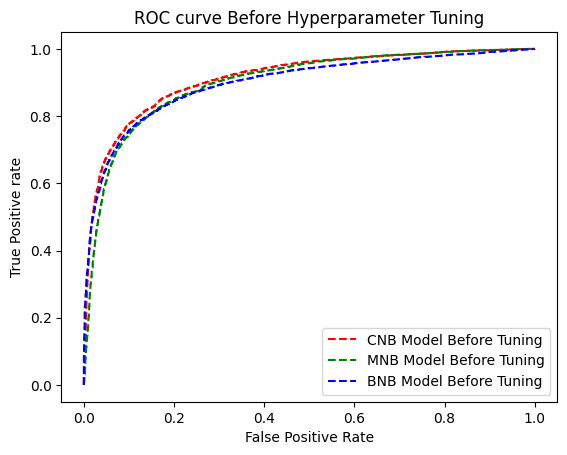

In [11]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

CNB_prob_before = cnb.predict_proba(x_test_vectorized)
MNB_prob_before = mnb.predict_proba(x_test_vectorized)
BNB_prob_before = bnb.predict_proba(x_test_vectorized)

fpr1_before, tpr1_before, _ = roc_curve(y_test, CNB_prob_before[:,1], pos_label=1)
fpr2_before, tpr2_before, _ = roc_curve(y_test, MNB_prob_before[:,1], pos_label=1)
fpr3_before, tpr3_before, _ = roc_curve(y_test, BNB_prob_before[:,1], pos_label=1)

#Plotting
plt.plot(fpr1_before, tpr1_before, linestyle='--',color='red', label='CNB Model Before Tuning')
plt.plot(fpr2_before, tpr2_before, linestyle='--',color='green', label='MNB Model Before Tuning')
plt.plot(fpr3_before, tpr3_before, linestyle='--',color='blue', label='BNB Model Before Tuning')

plt.title('ROC curve Before Hyperparameter Tuning')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC_Before_Tuning', dpi=300)
plt.show();

The ROC (Receiver Operating Characteristic) curve visually represents a model's performance by plotting the true positive rate against the false positive rate at various classification thresholds. It helps assess the trade-off between sensitivity (true positives) and specificity (false positives). A model with a curve closer to the top left corner indicates better performance, and the area under the curve (AUC) quantifies overall accuracy.

From the results given above, the complement model has the best ROC AUC score of 0.9203.

Here, we will do hyperparameter tuning for the 3 models and compare which model gives us a better accuracy after the model has been tuned.

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
#Vectorize the text data
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

#Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
}

#Perform GridSearchCV on multinomial model
grid_search = GridSearchCV(mnb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_vec, y_train)

#Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

#Get the best model and hyperparameters
best_clf = grid_search.best_estimator_
print(f'Best Hyperparameters: {grid_search.best_params_}')

#Make predictions on the test set with the best model
predictionsMNB = best_clf.predict(x_test_vec)

#Retrain the model using the best parameters
MNB_best_model = grid_search.best_estimator_
MNB_best_model.fit(x_train_vec, y_train)

#Calculate the accuracy
accuracyMNB = accuracy_score(y_test, predictionsMNB)
print(f'Accuracy for multinomial model: {accuracyMNB * 100}%')

#Calculate ROC AUC Score
MNB_prob = best_clf.predict_proba(x_test_vectorized)
MNB_roc_auc = roc_auc_score(y_test, MNB_prob, multi_class='ovr')
print(f'ROC AUC Score: {MNB_roc_auc:.4f}')

Best Parameters: {'alpha': 0.1}
Best Cross-Validation Score: 0.7866692882422336
Best Hyperparameters: {'alpha': 0.1}
Accuracy for multinomial model: 83.23699421965318%
ROC AUC Score: 0.9551


In [13]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
#Vectorize the text data
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

#Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
}

#Perform GridSearchCV on complement model
grid_search = GridSearchCV(cnb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_vec, y_train)

#Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

#Get the best model and hyperparameters
best_clf = grid_search.best_estimator_
print(f'Best Hyperparameters: {grid_search.best_params_}')

#Make predictions on the test set with the best model
predictionsCNB = best_clf.predict(x_test_vec)

#Retrain the model using the best parameters
CNB_best_model = grid_search.best_estimator_
CNB_best_model.fit(x_train_vec, y_train)

#Calculate the accuracy
accuracyCNB = accuracy_score(y_test, predictionsCNB)
print(f'Accuracy for complement model: {accuracyCNB * 100}%')

#Calculate ROC AUC Score
CNB_prob = best_clf.predict_proba(x_test_vectorized)
CNB_roc_auc = roc_auc_score(y_test, CNB_prob, multi_class='ovr')
print(f'ROC AUC Score: {CNB_roc_auc:.4f}')

Best Parameters: {'alpha': 1.0}
Best Cross-Validation Score: 0.7886944553676759
Best Hyperparameters: {'alpha': 1.0}
Accuracy for complement model: 82.74153592072668%
ROC AUC Score: 0.9410


In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
#Vectorize the text data
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test)

#Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0]
}

#Perform GridSearchCV on multinomial model
grid_search = GridSearchCV(bnb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train_vec, y_train)

#Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

#Get the best model and hyperparameters
best_clf = grid_search.best_estimator_
print(f'Best Hyperparameters: {grid_search.best_params_}')

#Make predictions on the test set with the best model
predictionsBNB = best_clf.predict(x_test_vec)

#Retrain the model using the best parameters
BNB_best_model = grid_search.best_estimator_
BNB_best_model.fit(x_train_vec, y_train)

#Calculate the accuracy
accuracyBNB = accuracy_score(y_test, predictionsBNB)
print(f'Accuracy for bernoulli model: {accuracyBNB * 100}%')

#Calculate ROC AUC Score
BNB_prob = best_clf.predict_proba(x_test_vectorized)
BNB_roc_auc = roc_auc_score(y_test, BNB_prob, multi_class='ovr')
print(f'ROC AUC Score: {BNB_roc_auc:.4f}')

Best Parameters: {'alpha': 0.1}
Best Cross-Validation Score: 0.7736924891860009
Best Hyperparameters: {'alpha': 0.1}
Accuracy for bernoulli model: 81.7643820533994%
ROC AUC Score: 0.9433


In [15]:
#Set roc_auc to best model
roc_auc = max(BNB_roc_auc, CNB_roc_auc, MNB_roc_auc)

#Determine the best model based on roc_auc
best_model = "BNB" if roc_auc == BNB_roc_auc else ("CNB" if roc_auc == CNB_roc_auc else "MNB")

#Set predictions to best model
predictions = globals()[f"predictions{best_model}"]

#Set accuracy to best model
accuracy = globals()[f"accuracy{best_model}"]

print(f'Best Model: {best_model}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')

Best Model: MNB
ROC AUC Score: 0.9551
Accuracy: 0.8324


After the hyperparameter tuning process, the best model based on the highest ROC AUC score and accuracy is the multinomial model. This means that the multinomial model is the most accurate in identifying negative, neutral and positive sentiments.

Lastly, we will do our final evaluation and analysis. Here, we plot the confusion matrix, classification report and roc auc graph for the multinomial model.

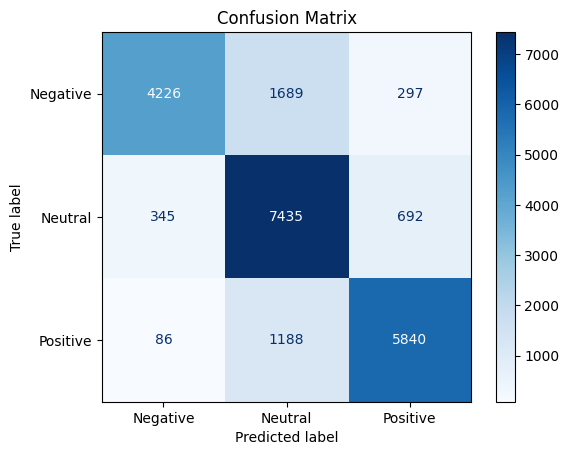

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
predictions = mnb.predict(x_test_vectorized)

#Plot the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [17]:
print(classification_report(y_test, mnb.predict(x_test_vectorized), target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.91      0.68      0.78      6212
     Neutral       0.72      0.88      0.79      8472
    Positive       0.86      0.82      0.84      7114

    accuracy                           0.80     21798
   macro avg       0.83      0.79      0.80     21798
weighted avg       0.82      0.80      0.80     21798



Based on the results given by the multinomial model, the model shows the highest precision for the "Negative" class, indicating that it is more likely to be correct when predicting a negative sentiment. Then it is followed by "Positive" then "Neutral".

---
However, when we look at the recall score, the order is in the complete opposite: the model has the highest recall for the "Neutral" class, meaning it is more effective at identifying true "Neutral" instances. Afterwards, it is followed by "Positive" then "Negative".


---

This analysis indicates that while the model is good at making accurate predictions for the "Negative" class when it does so, it struggles more with recall, particularly in this class. Conversely, it is better at capturing all "Neutral" instances but struggles with precision, leading to more false positives for "Neutral."


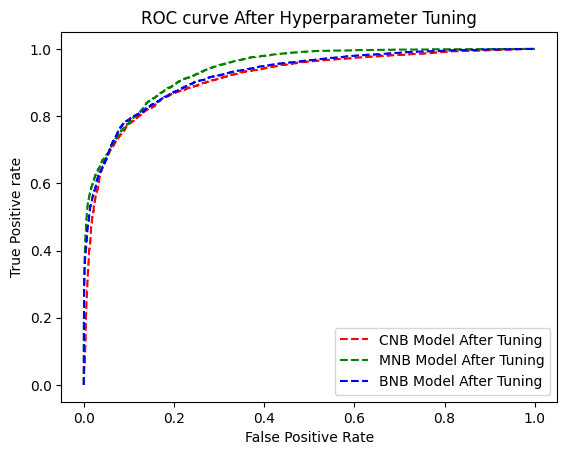

In [18]:
#After hyperparameter tuning, generate new predictions
CNB_prob_after = CNB_best_model.predict_proba(x_test_vectorized)
MNB_prob_after = MNB_best_model.predict_proba(x_test_vectorized)
BNB_prob_after = BNB_best_model.predict_proba(x_test_vectorized)

#ROC curve after hyperparameter tuning
fpr1_after, tpr1_after, _ = roc_curve(y_test, CNB_prob_after[:,1], pos_label=1)
fpr2_after, tpr2_after, _ = roc_curve(y_test, MNB_prob_after[:,1], pos_label=1)
fpr3_after, tpr3_after, _ = roc_curve(y_test, BNB_prob_after[:,1], pos_label=1)

#Plotting
plt.plot(fpr1_after, tpr1_after, linestyle='--',color='red', label='CNB Model After Tuning')
plt.plot(fpr2_after, tpr2_after, linestyle='--',color='green', label='MNB Model After Tuning')
plt.plot(fpr3_after, tpr3_after, linestyle='--',color='blue', label='BNB Model After Tuning')

plt.title('ROC curve After Hyperparameter Tuning')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('ROC_After_Tuning', dpi=300)
plt.show();


The ROC curve corresponds with our results above where the best model that is able to identify correct instances of the 3 classes is the multinomial model. In conclusion, the best model with the highest accuracy is the Multinomial model with ROC AUC score of 0.9375 and accuracy of 81%.

In [19]:
import joblib

# Save the model to a file
joblib.dump(MNB_best_model, 'naive_bayes_model.pkl')
joblib.dump(vectorizer, 'vectorizer.pkl')

print("Model saved successfully!")

Model saved successfully!
